# Crowdfunding Success Prediction

## Data Preprocessing

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from matplotlib import pyplot as plt
from scipy.stats import randint, uniform, boxcox
from scipy.stats.mstats import winsorize
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline

import utils

In [39]:
# load the excel file
df = pd.read_excel('../data/Crowdfunding campaign.xlsx', sheet_name='Sheet1')
df

,cid,pre_order_perk,amt_goal,frac_raised,tech_campaign,sbiz_campaign,fixed_fund,state,year_start,iot_plus,delivery
0,71762,0,2500,0.040000,0,1,0.0,Kentucky,2011,0.0,NaN
1,72367,0,1500,1.733333,0,0,0.0,Indiana,2012,0.0,NaN
2,73646,1,100000,1.007510,1,0,0.0,Louisiana,2012,0.0,NaN
3,74867,1,7000,0.000000,0,1,0.0,North Carolina,2012,0.0,NaN
4,82829,1,2000,1.000000,0,1,0.0,Pennsylvania,2011,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
434,242139,1,100000,2.139170,1,0,1.0,California,2013,1.0,NaN
435,242139,1,100000,2.139170,1,0,1.0,California,2013,1.0,NaN
436,242139,1,100000,2.139170,1,0,1.0,California,2013,1.0,NaN
437,250311,1,5000,1.007000,0,1,0.0,Kentucky,2012,0.0,NaN


In [40]:
# Check for missing values
df.isnull().sum()

cid                 0
pre_order_perk      0
amt_goal            0
frac_raised         0
tech_campaign       0
sbiz_campaign       0
fixed_fund          6
state               0
year_start          0
iot_plus            4
delivery          289
dtype: int64

In [41]:
# find duplicates
df[df.duplicated()]

,cid,pre_order_perk,amt_goal,frac_raised,tech_campaign,sbiz_campaign,fixed_fund,state,year_start,iot_plus,delivery
224,71762,0,2500,0.040000,0,1,0.0,Kentucky,2011,0.0,NaN
225,72367,0,1500,1.733333,0,0,0.0,Indiana,2012,0.0,NaN
226,72367,0,1500,1.733333,0,0,0.0,Indiana,2012,0.0,NaN
227,72367,0,1500,1.733333,0,0,0.0,Indiana,2012,0.0,NaN
228,73646,1,100000,1.007510,1,0,0.0,Louisiana,2012,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
434,242139,1,100000,2.139170,1,0,1.0,California,2013,1.0,NaN
435,242139,1,100000,2.139170,1,0,1.0,California,2013,1.0,NaN
436,242139,1,100000,2.139170,1,0,1.0,California,2013,1.0,NaN
437,250311,1,5000,1.007000,0,1,0.0,Kentucky,2012,0.0,NaN


In [42]:
# drop duplicates
df = df.drop_duplicates()
df

,cid,pre_order_perk,amt_goal,frac_raised,tech_campaign,sbiz_campaign,fixed_fund,state,year_start,iot_plus,delivery
0,71762,0,2500,0.040000,0,1,0.0,Kentucky,2011,0.0,NaN
1,72367,0,1500,1.733333,0,0,0.0,Indiana,2012,0.0,NaN
2,73646,1,100000,1.007510,1,0,0.0,Louisiana,2012,0.0,NaN
3,74867,1,7000,0.000000,0,1,0.0,North Carolina,2012,0.0,NaN
4,82829,1,2000,1.000000,0,1,0.0,Pennsylvania,2011,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
219,248410,0,1500,1.088000,0,1,0.0,Illinois,2012,0.0,NaN
220,248622,0,10000,1.005000,0,1,0.0,New York,2012,0.0,NaN
221,250311,1,5000,1.007000,0,1,0.0,Kentucky,2012,0.0,NaN
222,256062,1,2000,8.188500,1,0,0.0,Georgia,2013,0.0,1.0


In [43]:
# drop the "delivery" column
df = df.drop(columns=['delivery'])

In [44]:
# drop rows with missing values
df = df.dropna()

In [45]:
# check the data types
df.dtypes

cid                 int64
pre_order_perk      int64
amt_goal            int64
frac_raised       float64
tech_campaign       int64
sbiz_campaign       int64
fixed_fund        float64
state              object
year_start          int64
iot_plus          float64
dtype: object

In [46]:
# check the number of 0's in the target variable
df['frac_raised'].value_counts()

frac_raised
0.0000    46
1.0000    10
1.7500     3
1.0200     3
1.0050     2
          ..
3.2428     1
0.0080     1
9.5830     1
1.9240     1
8.1885     1
Name: count, Length: 156, dtype: int64

## Exploratory Data Analysis

In [47]:
# Describe the data
df.describe()

,cid,pre_order_perk,amt_goal,frac_raised,tech_campaign,sbiz_campaign,fixed_fund,year_start,iot_plus
count,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.00000
mean,164216.592593,0.509259,17533.518519,1.801634,0.462963,0.412037,0.212963,2012.648148,0.12037
std,41130.626378,0.501076,31481.563736,3.699447,0.499785,0.493345,0.410353,0.567570,0.32615
min,71762.000000,0.000000,500.000000,0.000000,0.000000,0.000000,0.000000,2011.000000,0.00000
25%,137707.750000,0.000000,1462.500000,0.008788,0.000000,0.000000,0.000000,2012.000000,0.00000
50%,158916.000000,1.000000,5000.000000,1.019715,0.000000,0.000000,0.000000,2013.000000,0.00000
75%,194429.500000,1.000000,15000.000000,1.750967,1.000000,1.000000,0.000000,2013.000000,0.00000
max,256198.000000,1.000000,200000.000000,25.918080,1.000000,1.000000,1.000000,2013.000000,1.00000


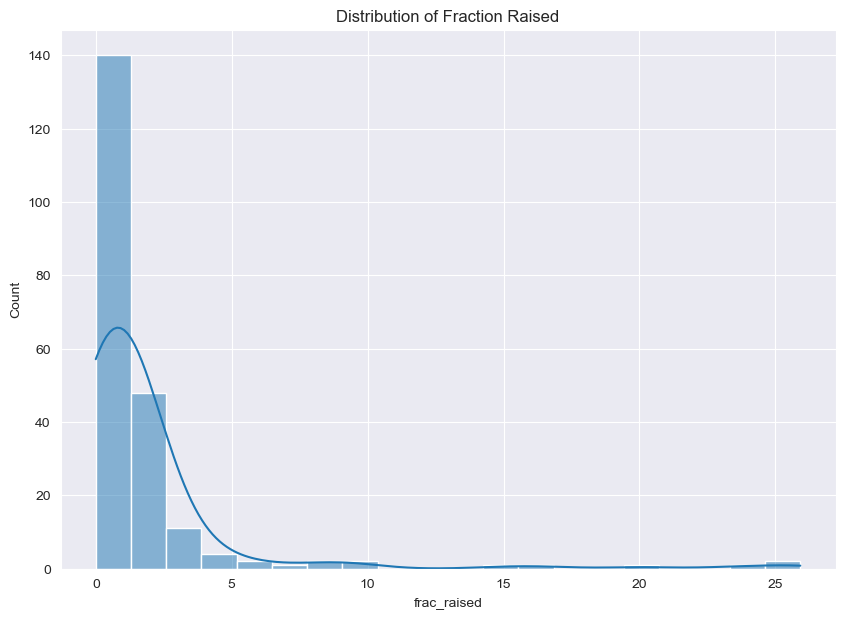

In [48]:
# Check the distribution of the target variable
plt.figure(figsize=(10, 7))
sns.histplot(df['frac_raised'], bins=20, kde=True)
plt.title('Distribution of Fraction Raised')
plt.show()

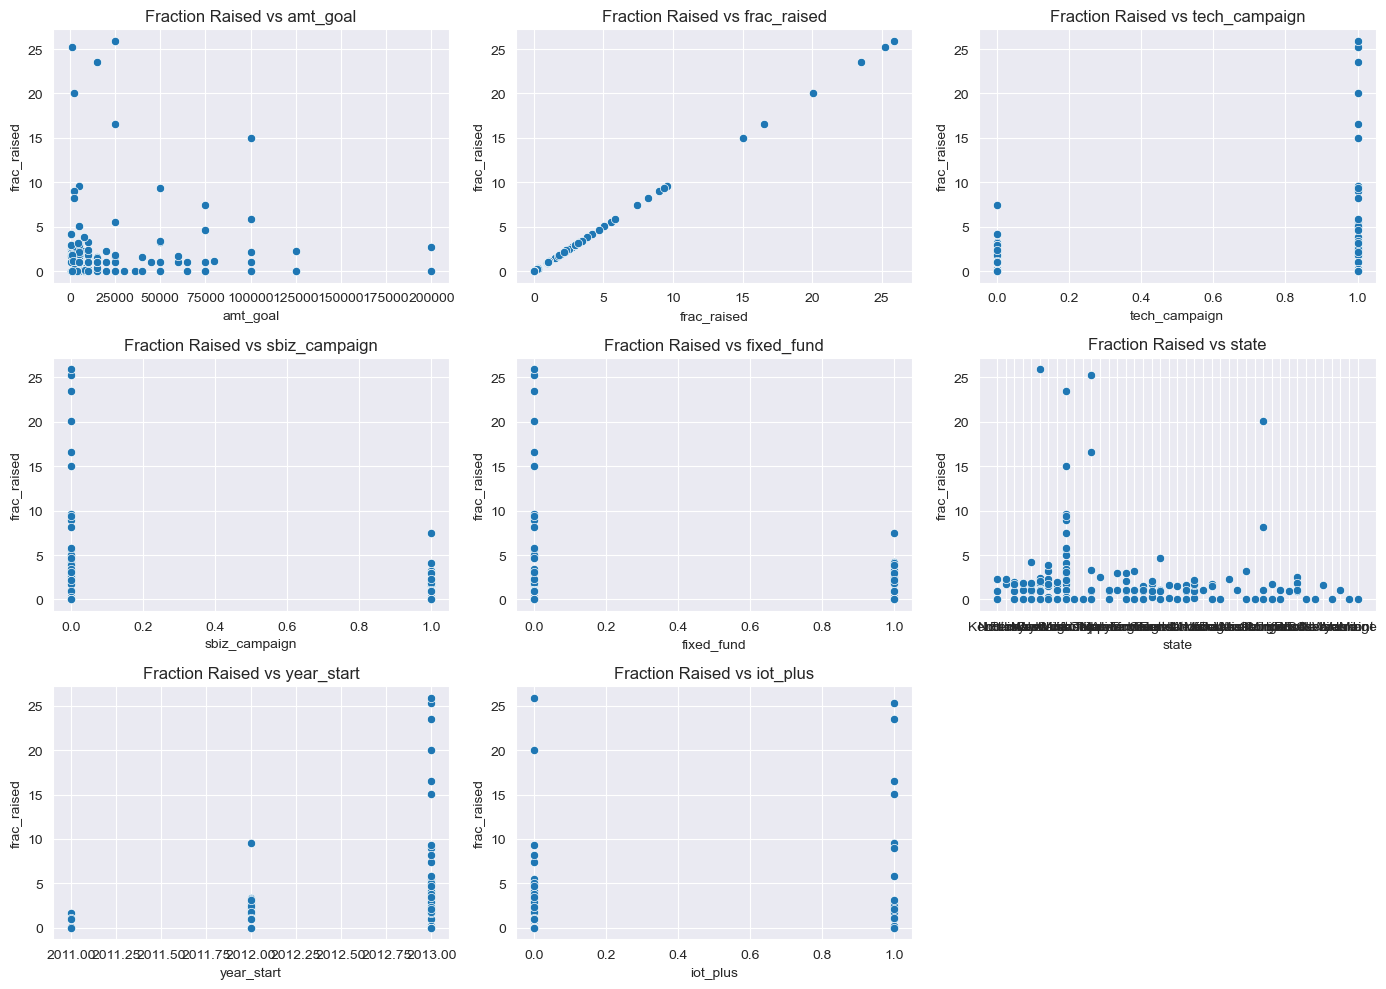

In [49]:
# plot the target variable against the dependent variables
plt.figure(figsize=(14, 10))
for i, col in enumerate(df.columns[2:]):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(data=df, x=col, y='frac_raised')
    plt.title(f'Fraction Raised vs {col}')
plt.tight_layout()
plt.show()

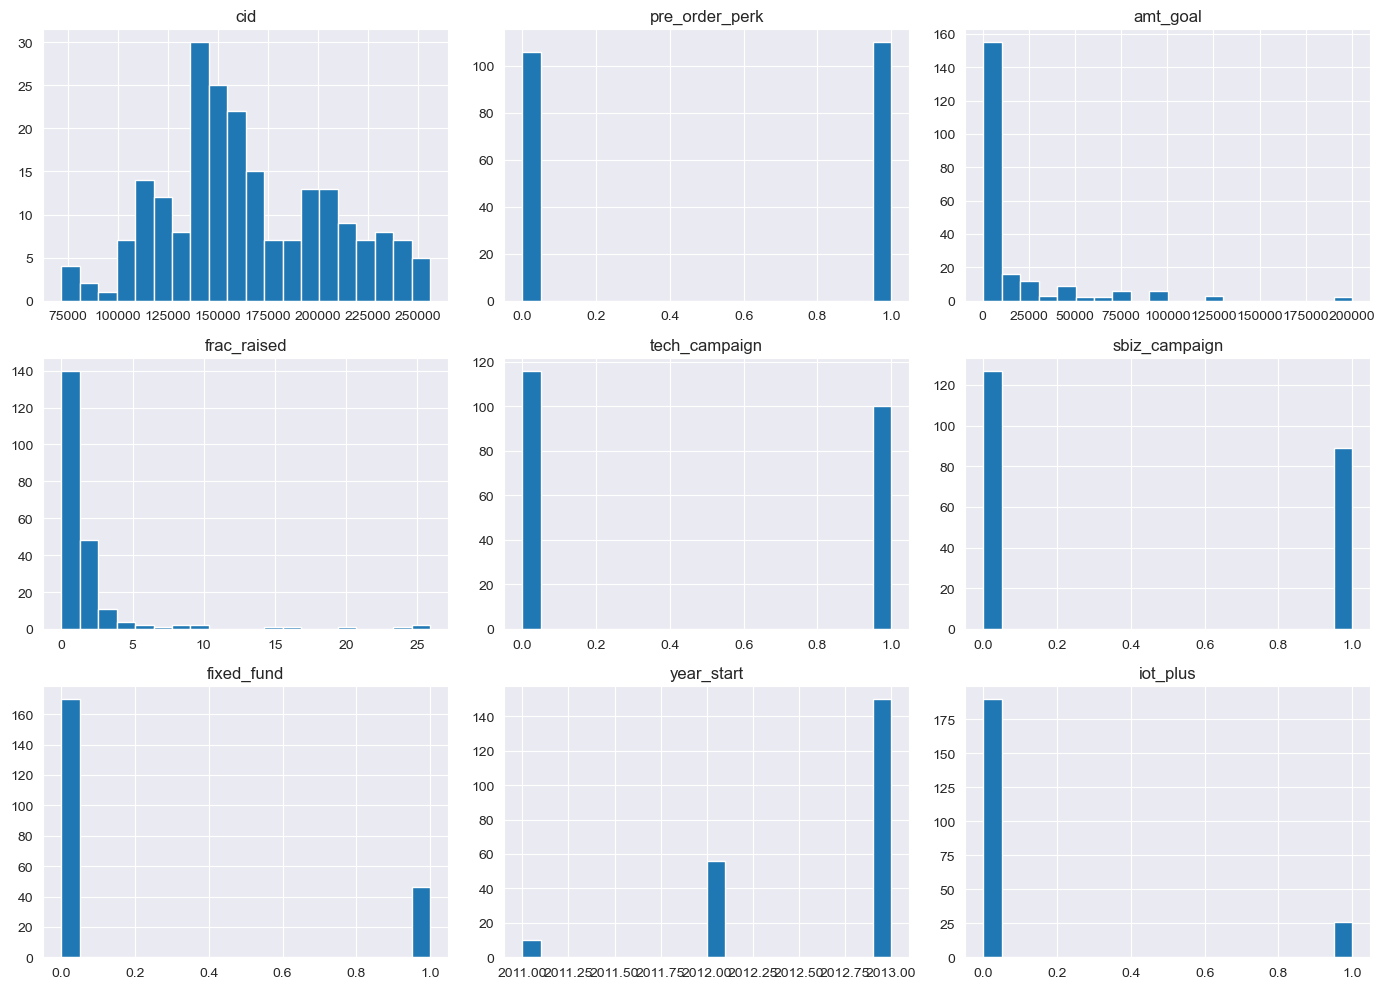

In [50]:
#Inspect the data, check skewness, outliers
df.hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

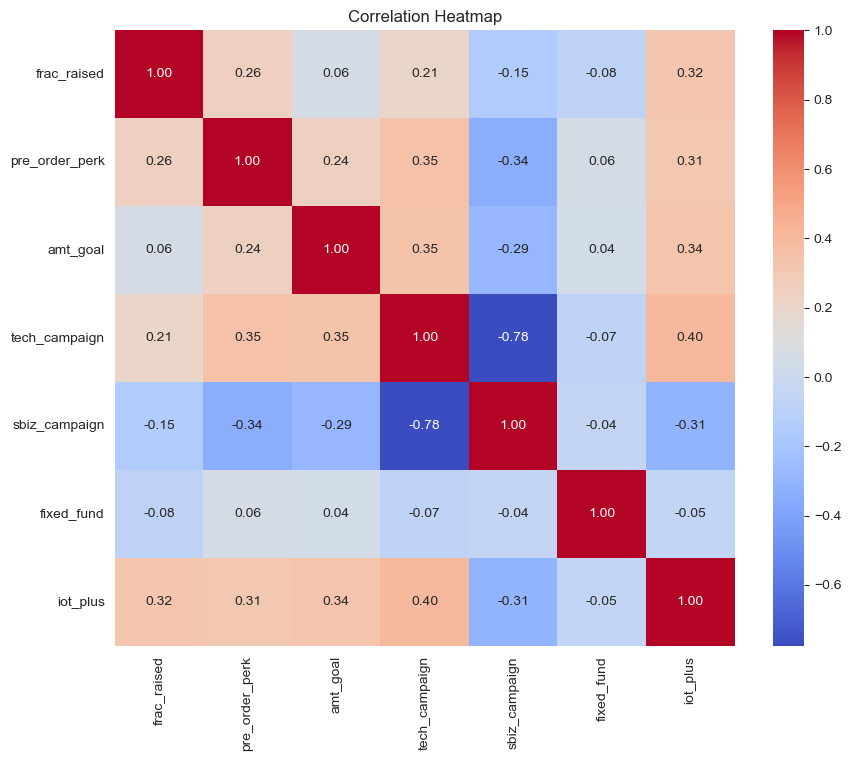

In [51]:
# Correlation heatmap (year and cid are exclued)
plt.figure(figsize=(10, 8))
sns.heatmap(df[["frac_raised", "pre_order_perk", "amt_goal", "tech_campaign", "sbiz_campaign", "fixed_fund",
                "iot_plus"]].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Feature Engineering

In [52]:
# Split the data into features and target
X = df.drop(columns=['cid', 'state', 'frac_raised'])
y = df['frac_raised']

### Remove Highly Correlated Features

In [53]:
# remove columns with high multicollinearity
X_vif = utils.calculate_vif(X, threshold=5)
X = X_vif
X

Removed variables with high VIF:
year_start: 10.02


,pre_order_perk,amt_goal,tech_campaign,sbiz_campaign,fixed_fund,iot_plus
0,0,2500,0,1,0.0,0.0
1,0,1500,0,0,0.0,0.0
2,1,100000,1,0,0.0,0.0
3,1,7000,0,1,0.0,0.0
4,1,2000,0,1,0.0,0.0
...,...,...,...,...,...,...
219,0,1500,0,1,0.0,0.0
220,0,10000,0,1,0.0,0.0
221,1,5000,0,1,0.0,0.0
222,1,2000,1,0,0.0,0.0


### Handle Outliers

In [54]:
# winsorize the features
X = X.apply(lambda x: winsorize(x, limits=[0.05, 0.05]))

In [55]:
# winsorize the target variable
y = winsorize(y, limits=[0.05, 0.05])

### Log Transformation

#### Features Transformation

In [56]:
log_X = X.copy()

In [57]:
# log transform amt_goal
log_X['amt_goal'] = np.log1p(log_X['amt_goal'])

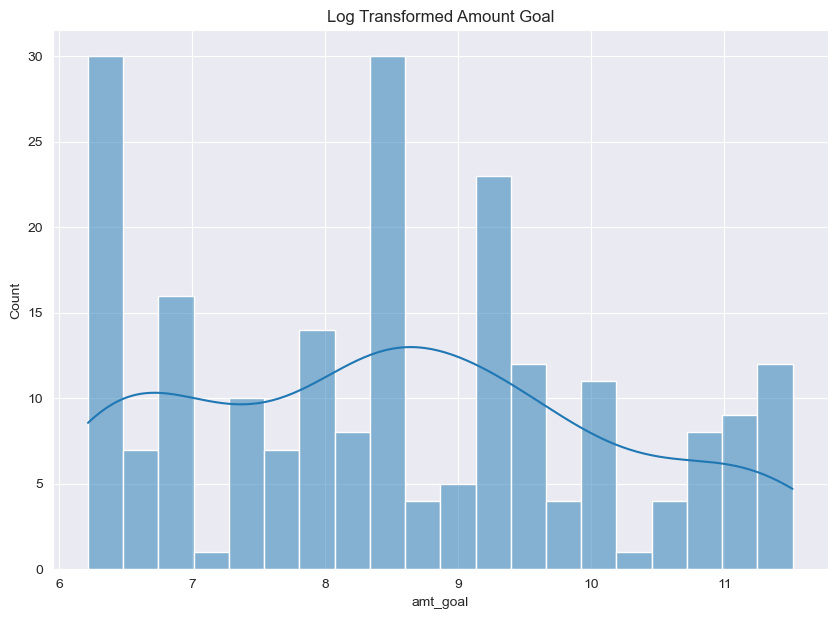

In [58]:
# plot log transformed amt_goal
plt.figure(figsize=(10, 7))
sns.histplot(log_X['amt_goal'], bins=20, kde=True)
plt.title('Log Transformed Amount Goal')
plt.show()

### Target Transformation

In [59]:
log_y = y.copy()

In [60]:
log_y = np.sqrt(log_y)

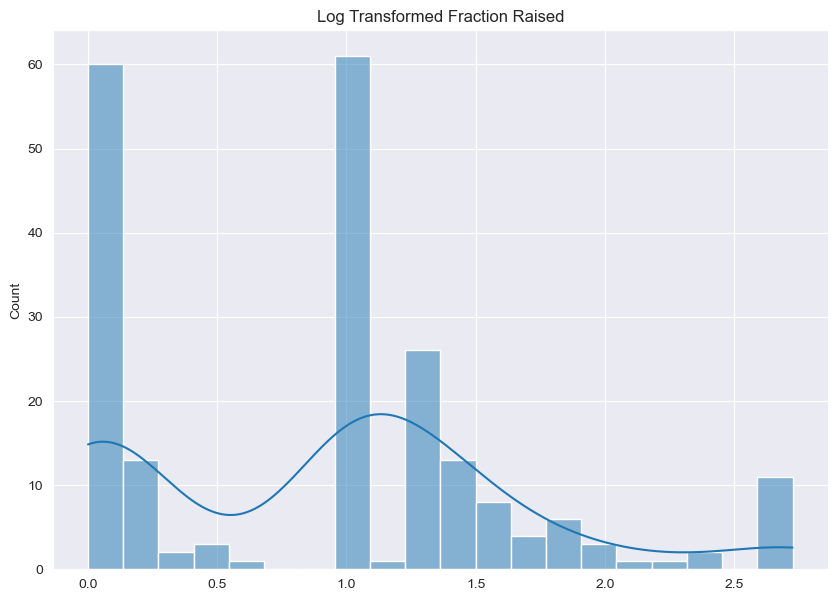

In [61]:
# plot the log transformed target variable
plt.figure(figsize=(10, 7))
sns.histplot(log_y, bins=20, kde=True)
plt.title('Log Transformed Fraction Raised')
plt.show()

## Model Selection

### Scoring and Cross-Validation

In [62]:
# Define a custom scorer
r2_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [63]:
# Define the cross-validation strategy
cv = KFold(n_splits=10, shuffle=True, random_state=42)

### Linear Regression

#### OLS Statsmodels Output

In [64]:
# add a constant to the features
X_ols = log_X.copy()
X_ols = sm.add_constant(X_ols)

# fit the model
ols_model = sm.OLS(y, X_ols)
ols_results = ols_model.fit()

# print the summary
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     6.868
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           1.14e-06
Time:                        11:06:04   Log-Likelihood:                -411.66
No. Observations:                 216   AIC:                             837.3
Df Residuals:                     209   BIC:                             861.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.4108      0.712      1.

##### Robust Standard Errors

In [65]:
results_adjusted = ols_results.get_robustcov_results(cov_type='HC3')
print(results_adjusted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     4.602
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           0.000206
Time:                        11:06:04   Log-Likelihood:                -411.66
No. Observations:                 216   AIC:                             837.3
Df Residuals:                     209   BIC:                             861.0
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.4108      0.814      1.

##### Autocorrelation

In [66]:
results_robust = ols_results.get_robustcov_results(cov_type='HAC', maxlags=1)
print(results_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     4.775
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           0.000139
Time:                        11:06:04   Log-Likelihood:                -411.66
No. Observations:                 216   AIC:                             837.3
Df Residuals:                     209   BIC:                             861.0
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.4108      0.789      1.

#### Sklearn Linear Regression

In [67]:
# create a pipeline with standard scaler and linear regression
lr_model = make_pipeline(StandardScaler(), LinearRegression())

# evaluate the model
y_pred_lr = cross_val_predict(lr_model, log_X, y, cv=cv)

# calculate the mean r2 using the predictions
r2_score(y, y_pred_lr)

0.08451462755524863

In [68]:
#y_pred_lr = np.expm1(y_pred_lr)

### Random Forest

In [69]:
# create a random forest model
rf_model = RandomForestRegressor(random_state=42)

# evaluate the model
y_pred_rf = cross_val_predict(rf_model, X, y, cv=cv)

# calculate the mean mae using the predictions
mean_absolute_error(y, y_pred_rf)

1.3505407527449573

In [70]:
# back-transform the predictions
#y_pred_rf = np.expm1(y_pred_rf)

#### Hyperparameter Tuning

In [71]:
param_distributions_rf = {
    'n_estimators': randint(100, 1000),  # Number of trees (100 to 1000)
    'max_depth': randint(1, 10),  # Depth of trees (1 to 10)
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 10),  # Minimum number of samples required in a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for best split
    'bootstrap': [True, False],  # Whether to use bootstrapping
}

In [72]:
# create a random search object
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions_rf,
    n_iter=100,
    scoring=r2_scorer,
    cv=cv,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

rf_random_search.fit(X, y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17657b190>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1691894d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1766f0610>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17651d3d0>},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                   verbose=2)

In [73]:
# Print the best parameters and score
print("Best Parameters: ", rf_random_search.best_params_)
print("Best Score: ", rf_random_search.best_score_)

Best Parameters:  {'bootstrap': True, 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 211}
Best Score:  -1.174777874880857


In [74]:
y_pred_rf_hyper = cross_val_predict(rf_random_search.best_estimator_, X, y, cv=cv)

In [75]:
#y_pred_rf_hyper = np.expm1(y_pred_rf_hyper)

### AdaBoost

In [76]:
# define a base model
base_model = DecisionTreeRegressor(max_depth=1, random_state=42)

# create an AdaBoost model
ab_model = AdaBoostRegressor(estimator=base_model, random_state=42)

# evaluate the model
y_pred_ab = cross_val_predict(ab_model, X, y, cv=cv)

# calculate the mean r2 using the predictions
mean_absolute_error(y, y_pred_ab)

1.179510249327494

In [77]:
#y_pred_ab = np.expm1(y_pred_ab)

#### Hyperparameter Tuning

In [78]:
param_distributions_ada = {
    'n_estimators': randint(1, 100),  # Number of boosting stages
    'learning_rate': uniform(0.01, 2),  # Shrinkage step size
    'estimator__max_depth': randint(1, 10),  # Tuning max depth of base decision tree
    'estimator__min_samples_split': randint(2, 20),  # Min samples to split in the base tree
    'estimator__min_samples_leaf': randint(1, 10),  # Min samples for leaves
}

In [79]:
# create a random search object
ada_random_search = RandomizedSearchCV(
    estimator=ab_model,
    param_distributions=param_distributions_ada,
    n_iter=100,
    scoring=r2_scorer,
    cv=cv,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

ada_random_search.fit(X, y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.2s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estimators=971; total time=   0.7s
[CV] END bootstrap=False, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=559; total time=   0.3s
[CV] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=559; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=9, min_samples_split=18, n_estimators=574; tota

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1,
                                                                               random_state=42),
                                               random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'estimator__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17666f350>,
                                        'estimator__min_samples_leaf': <scip...
                                        'estimator__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17674e350>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x176731410>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17668b310>},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                   verbose=2)

In [80]:
# Print the best parameters and score
print("Best Parameters: ", ada_random_search.best_params_)
print("Best Score: ", ada_random_search.best_score_)

Best Parameters:  {'estimator__max_depth': 1, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 6, 'learning_rate': 0.9583476581746504, 'n_estimators': 90}
Best Score:  -1.1700853909789897


In [81]:
y_pred_ab_hyper = cross_val_predict(ada_random_search.best_estimator_, X, y, cv=cv)

In [82]:
#y_pred_ab_hyper = np.expm1(y_pred_ab_hyper)

### XGBoost

In [83]:
xgb_model = xgb.XGBRegressor()

# evaluate the model
y_pred_xgb = cross_val_predict(xgb_model, X, y, cv=cv)

# calculate the mean MAE using the predictions
mean_absolute_error(y, y_pred_xgb)

1.443459131006018

In [84]:
#y_pred_xgb = np.expm1(y_pred_xgb)

#### Hyperparameter Tuning

In [85]:
# Define the parameter distribution for GridSearchCV
param_distributions_xgb = {
    'n_estimators': randint(1, 100),  # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.3),  # Step size shrinkage
    'max_depth': randint(1, 15),  # Maximum depth of a tree
    'min_child_weight': randint(1, 10),  # Minimum sum of instance weight (hessian) needed in a child
    'gamma': uniform(0, 0.5),  # Minimum loss reduction to make a split
    'subsample': uniform(0.1, 0.9),  # Subsample ratio of the training data
    'colsample_bytree': uniform(0.1, 0.9),  # Subsample ratio of columns when constructing each tree
    'scale_pos_weight': randint(1, 10),  # Controls the balance of positive and negative classes
}

In [86]:
# create a random search object
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions_xgb,
    n_iter=100,
    scoring=r2_scorer,
    cv=cv,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

xgb_random_search.fit(X, y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END bootstrap=True, max_depth=9, max_features=None, min_samples_leaf=5, min_samples_split=11, n_estimators=285; total time=   1.4s
[CV] END bootstrap=True, max_depth=9, max_features=None, min_samples_leaf=5, min_samples_split=11, n_estimators=285; total time=   1.8s
[CV] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=7, min_samples_split=12, n_estimators=942; total time=   1.2s
[CV] END bootstrap=False, max_depth=9, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=618; total time=   0.6s
[CV] END bootstrap=False, max_depth=9, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=618; total time=   0.5s
[CV] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=9, min_samples_split=19, n_estimators=894; total time=   0.7s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=7, n_estimators=438; t

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=No...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16979b350>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1767a0850>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1779ba310>},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                   verbose=2)

In [87]:
# Print the best parameters and score
print("Best Parameters: ", xgb_random_search.best_params_)
print("Best Score: ", xgb_random_search.best_score_)

Best Parameters:  {'colsample_bytree': 0.8795585311974417, 'gamma': 0.3005575058716044, 'learning_rate': 0.22242177333881366, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 2, 'scale_pos_weight': 8, 'subsample': 0.8491983767203796}
Best Score:  -1.1524102962642004


In [88]:
y_pred_xgb_hyper = cross_val_predict(xgb_random_search.best_estimator_, X, y, cv=cv)

In [89]:
#y_pred_xgb_hyper = np.expm1(y_pred_xgb_hyper)

### Support Vector Machine

In [90]:
# create a pipeline with standard scaler and support vector machine
svm_model = make_pipeline(StandardScaler(), SVR())

# evaluate the model
y_pred_svm = cross_val_predict(svm_model, log_X, y, cv=cv)

# calculate the mean MAE using the predictions
mean_absolute_error(y, y_pred_svm)

1.132800803089271

In [91]:
#y_pred_svm = np.expm1(y_pred_svm)

#### Hyperparameter Tuning

In [92]:
# Define the parameter distribution for RandomizedSearchCV
param_distributions_svm = {
    'svr__C': uniform(0.1, 10),  # Regularization parameter
    'svr__gamma': ['scale', 'auto'],  # Kernel coefficient
    'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'svr__degree': randint(1, 10),  # Degree of the polynomial kernel
}

In [93]:
# create a random search object
svm_random_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_distributions_svm,
    n_iter=100,
    scoring=r2_scorer,
    cv=cv,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

svm_random_search.fit(log_X, y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END colsample_bytree=0.6069480147787453, gamma=0.34775804321306375, learning_rate=0.051799436321762704, max_depth=7, min_child_weight=4, n_estimators=13, scale_pos_weight=7, subsample=0.3607763076223912; total time=   0.0s
[CV] END colsample_bytree=0.6069480147787453, gamma=0.34775804321306375, learning_rate=0.051799436321762704, max_depth=7, min_child_weight=4, n_estimators=13, scale_pos_weight=7, subsample=0.3607763076223912; total time=   0.0s
[CV] END colsample_bytree=0.7098079256580542, gamma=0.008293914463928076, learning_rate=0.1636279174897843, max_depth=3, min_child_weight=4, n_estimators=96, scale_pos_weight=7, subsample=0.2569297861044923; total time=   0.0s
[CV] END colsample_bytree=0.7098079256580542, gamma=0.008293914463928076, learning_rate=0.1636279174897843, max_depth=3, min_child_weight=4, n_estimators=96, scale_pos_weight=7, subsample=0.2569297861044923; total time=   0.0s
[CV] END colsample_bytree

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svr', SVR())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x176655c90>,
                                        'svr__degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1693fe550>,
                                        'svr__gamma': ['scale', 'auto'],
                                        'svr__kernel': ['linear', 'poly', 'rbf',
                                                        'sigmoid']},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                   verbose=2)

In [94]:
# Print the best parameters and score
print("Best Parameters: ", svm_random_search.best_params_)
print("Best Score: ", svm_random_search.best_score_)

Best Parameters:  {'svr__C': 0.28075363615520865, 'svr__degree': 5, 'svr__gamma': 'auto', 'svr__kernel': 'sigmoid'}
Best Score:  -1.1160651815458142


In [95]:
y_pred_svm_hyper = cross_val_predict(svm_random_search.best_estimator_, X, y, cv=cv)

In [96]:
#y_pred_svm_hyper = np.expm1(y_pred_svm_hyper)

## Results

### Linear Regression

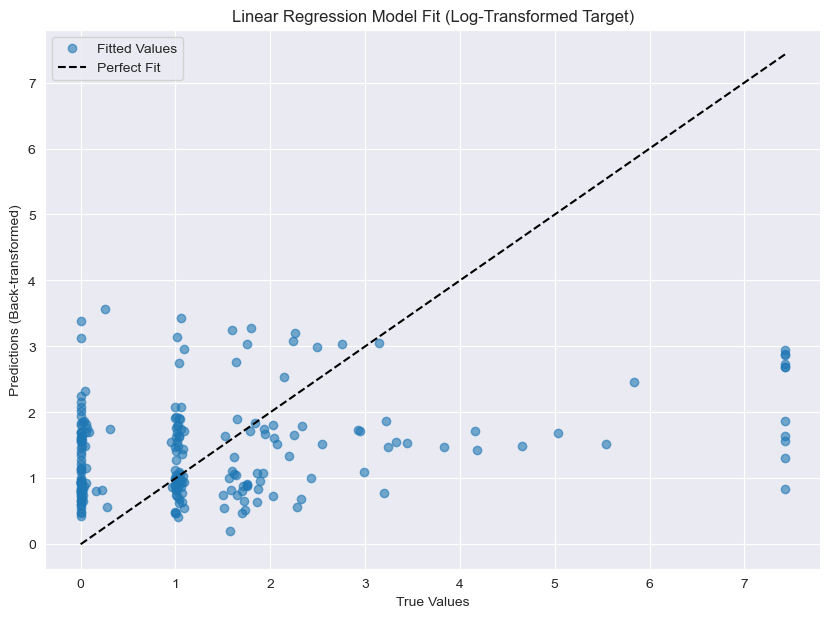

In [97]:
plt.figure(figsize=(10, 7))
plt.scatter(y, y_pred_lr, label='Fitted Values', alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], '--k', label='Perfect Fit')  # Reference line
plt.xlabel('True Values')
plt.ylabel('Predictions (Back-transformed)')
plt.title('Linear Regression Model Fit (Log-Transformed Target)')
plt.legend()
plt.show()

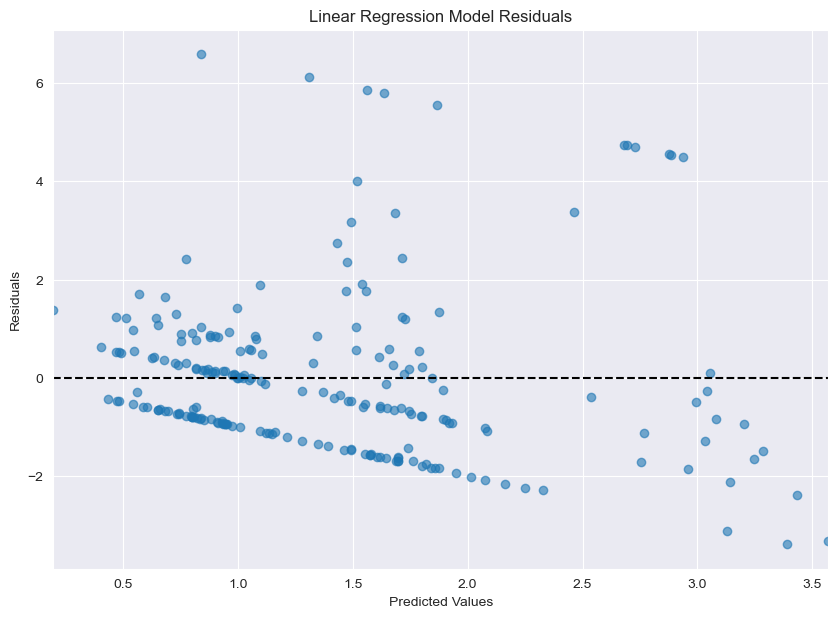

In [98]:
# Calculate residuals
residuals = y - y_pred_lr

# Plotting
plt.figure(figsize=(10, 7))
plt.scatter(y_pred_lr, residuals, alpha=0.6)
plt.axhline(0, color='k', linestyle='--')  # Reference line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Linear Regression Model Residuals')
plt.xlim([min(y_pred_lr), max(y_pred_lr)])  # Set x-axis limits based on fitted values
plt.show()

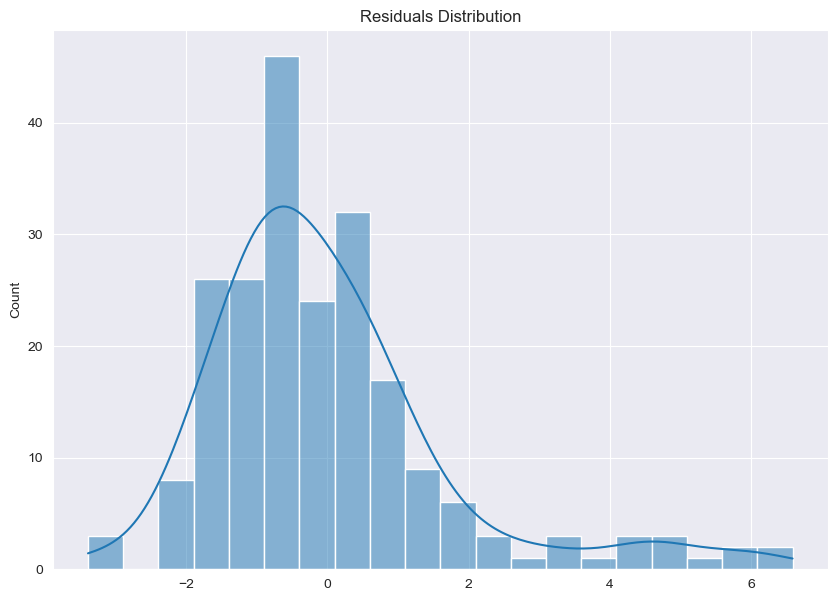

In [99]:
# plot residuals distribution
plt.figure(figsize=(10, 7))
sns.histplot(residuals, bins=20, kde=True)
plt.title('Residuals Distribution')
plt.show()

<Figure size 1000x700 with 0 Axes>

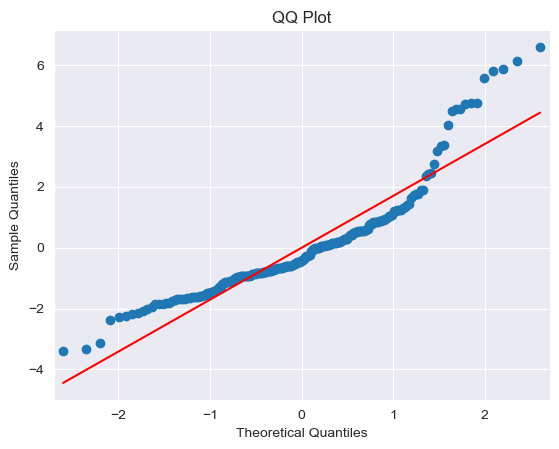

In [100]:
# plot qq plot
plt.figure(figsize=(10, 7))
sm.qqplot(residuals, line='s')
plt.title('QQ Plot')
plt.show()

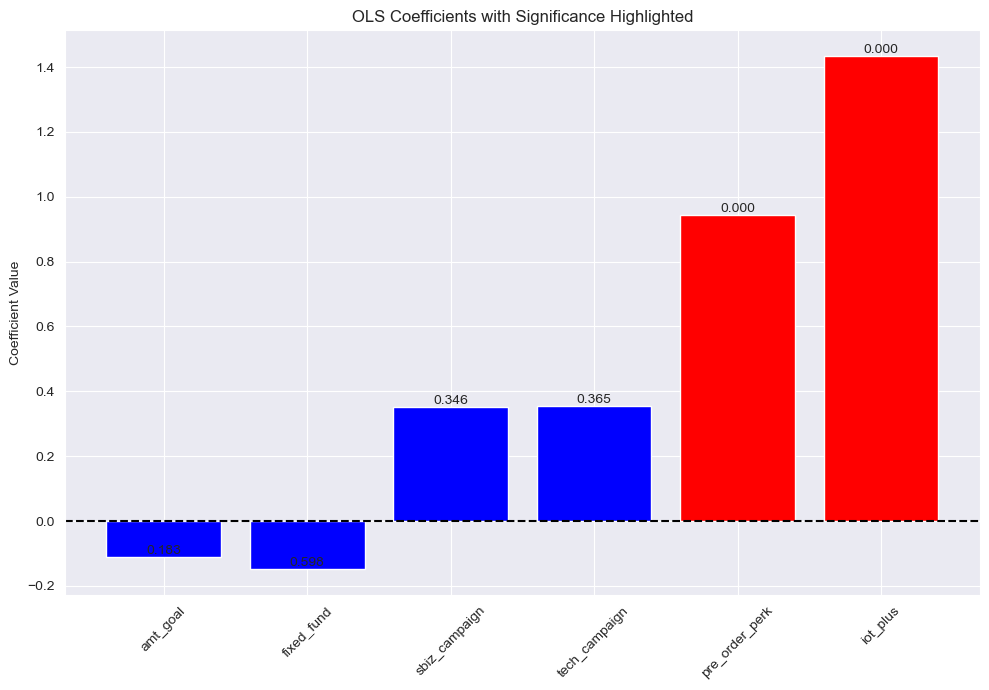

In [101]:
# Assuming ols_results is your fitted model with params and pvalues
utils.plot_coefficients(ols_results)

### Support Vector Machine

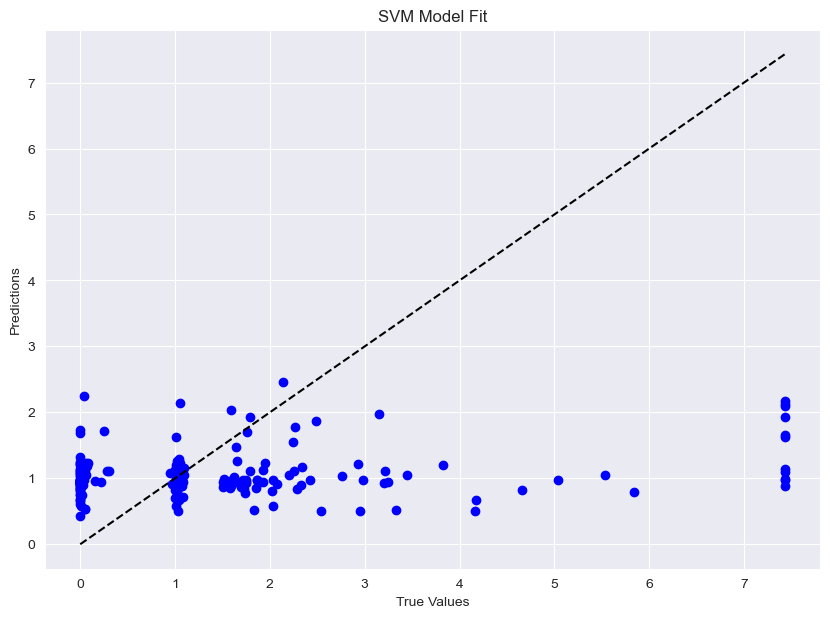

In [102]:
# plot actual vs predicted values
plt.figure(figsize=(10, 7))
plt.scatter(y, y_pred_svm_hyper, color='blue')
plt.plot([min(y), max(y)], [min(y), max(y)], '--k', label='Perfect Fit')  # Reference line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('SVM Model Fit')
plt.show()

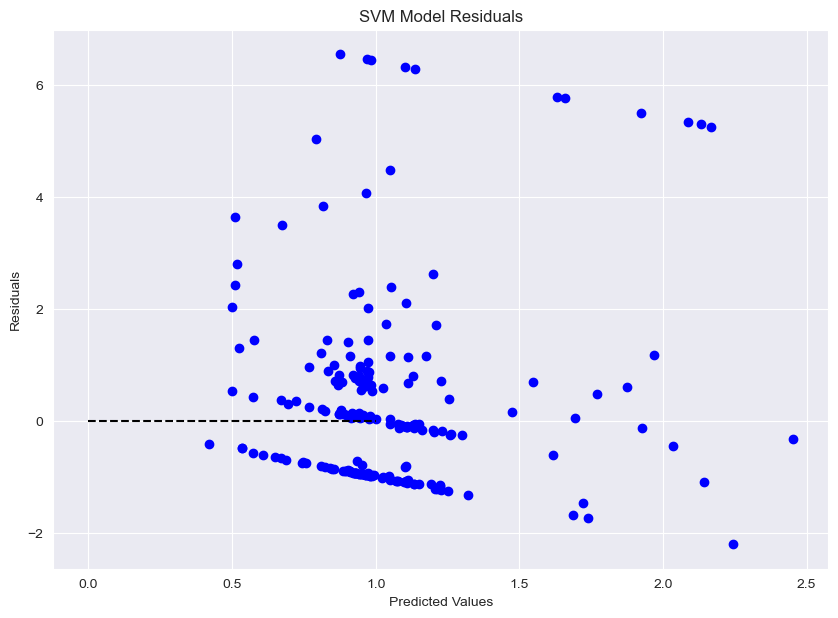

In [103]:
# plot residuals
plt.figure(figsize=(10, 7))
residuals = y - y_pred_svm_hyper
plt.scatter(y_pred_svm_hyper, residuals, color='blue')
plt.plot([0, 1], [0, 0], '--k')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('SVM Model Residuals')
plt.show()

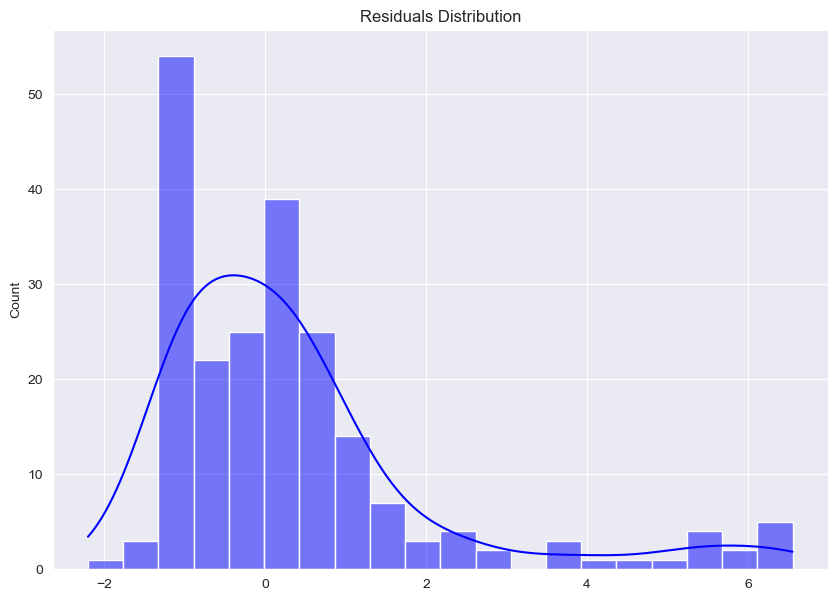

In [104]:
# plot residuals distribution
plt.figure(figsize=(10, 7))
sns.histplot(residuals, bins=20, kde=True, color='blue')
plt.title('Residuals Distribution')
plt.show()

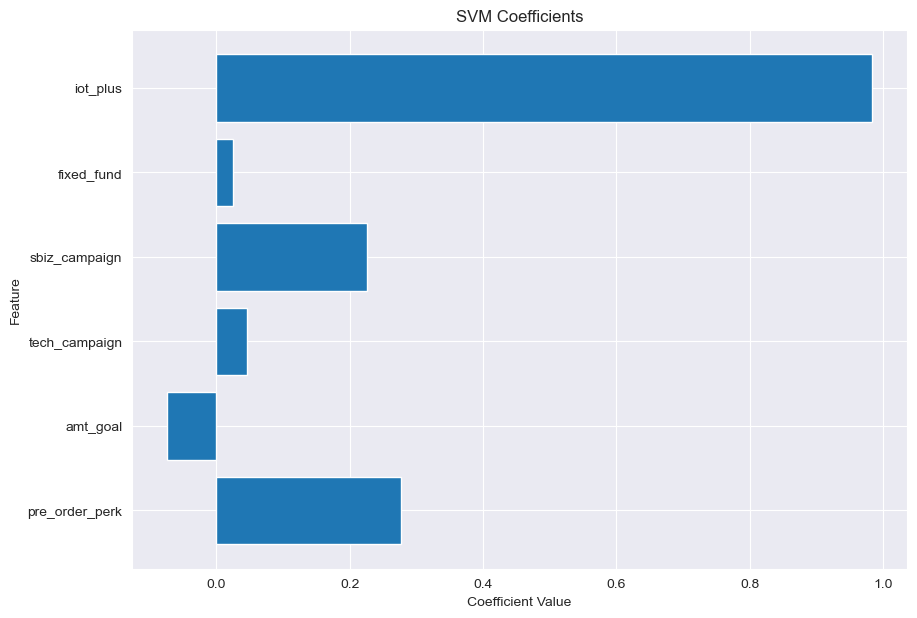

In [105]:
svm_coef_model = SVR(kernel='linear').fit(log_X, y)
plt.figure(figsize=(10, 7))
# sort the coefficients
plt.barh(X.columns, svm_coef_model.coef_[0])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('SVM Coefficients')
plt.show()

# Combined Model Scores

In [106]:
models = ['Linear Regression', 'SVM', 'Random Forest', 'AdaBoost', 'XGBoost']
predictions_base = [y_pred_lr, y_pred_svm, y_pred_rf, y_pred_ab, y_pred_xgb]
predictions_hyper = [y_pred_lr, y_pred_svm_hyper, y_pred_rf_hyper, y_pred_ab_hyper, y_pred_xgb_hyper]

results = utils.evaluate_models(models, predictions_base, predictions_hyper, X, y, task='regression')
results

,,Linear Regression,SVM,Random Forest,AdaBoost,XGBoost,Best Model,Best Value
Metric,Type,,,,,,,
Mean Absolute Error,Base,1.2098,1.132801,1.350541,1.17951,1.443459,SVM,1.110694
Mean Squared Error,Base,2.902252,3.183131,3.490433,2.953449,4.269555,AdaBoost,2.824574
Root Mean Squared Error,Base,1.7036,1.784133,1.86827,1.71856,2.06629,AdaBoost,1.680647
R-squared,Base,0.084515,-0.004086,-0.101021,0.068365,-0.346787,AdaBoost,0.109017
Adjusted R-squared,Base,0.058233,-0.032911,-0.132629,0.041619,-0.385451,AdaBoost,0.083439
Mean Absolute Error,Hyperparameter Tuning,1.2098,1.110694,1.175491,1.17009,1.152981,SVM,1.110694
Mean Squared Error,Hyperparameter Tuning,2.902252,3.082636,2.962648,2.824574,2.974951,AdaBoost,2.824574
Root Mean Squared Error,Hyperparameter Tuning,1.7036,1.755744,1.721234,1.680647,1.724805,AdaBoost,1.680647
R-squared,Hyperparameter Tuning,0.084515,0.027614,0.065463,0.109017,0.061582,AdaBoost,0.109017
